## Creating a Galaxy Distribution 

### Generating a cosmology with CAMB

Below, we choose a cosmology and generate matter shells and their angular power spectra using glass.shells and camb. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS imports: matter, random fields, random points, galaxies
import glass.shells
import glass.fields
import glass.points
import glass.galaxies
import glass.ext.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation. Make sure lmax is below 2nside, otherwise you will get aliasing/unreliable
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# uniform matter weight function, dz = 0.001 by default, but can be made smaller for more accuracy
ws = glass.shells.tophat_windows(zb)

# linear ramp matter weight function, dz = 0.001 by default, but can be made smaller for more accuracy
ws_ramp = glass.shells.tophat_windows(zb, weight=glass.ext.camb.camb_tophat_weight)

In [2]:
# compute angular matter power spectra with CAMB
#cls = glass.ext.camb.matter_cls(pars, lmax, ws)
# cls_ramp = glass.ext.camb.matter_cls(pars, lmax, ws_ramp)

# np.save('cls200.npy', cls)
# np.save('cls200ramp.npy', cls_ramp)

### Plotting the window function chosen above 
The window function chosen here is a constant-weight tophat function. In the examples, both this constant weight tophat and the linear ramp tophat are used in order to generate the window function. According to the GLASS paper, we should use B, since: " To work around a numerical issue in CAMB for flat matter weight functions that do not go to zero at z = 0, we slightly modify (3) to increase linearly from zero at
z = 0 to unity at z = 0.1, which is an otherwise negligible change." This workaround is the ramp.

Option A: uniform matter weight function  
`ws = glass.shells.tophat_windows(zb)`
  
Option B: CAMB requires linear ramp for low redshifts  
`ws_ramp = glass.shells.tophat_windows(zb, weight=glass.ext.camb.camb_tophat_weight)`

Text(0, 0.5, 'Window Function Weight')

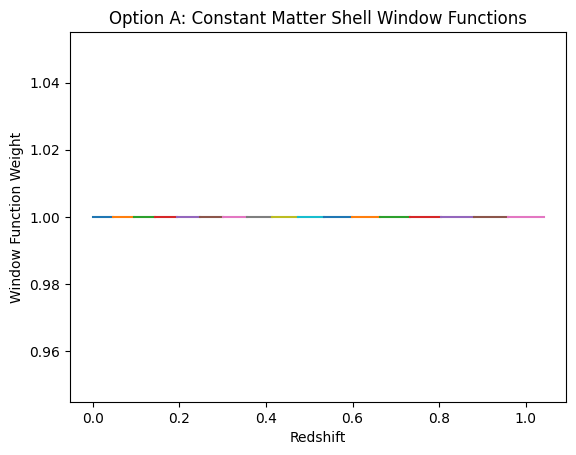

In [3]:
for i in ws:
    plt.plot(i.za, i.wa)
plt.title("Option A: Constant Matter Shell Window Functions")
plt.xlabel("Redshift")
plt.ylabel("Window Function Weight")

Text(0, 0.5, 'Window Function Weight')

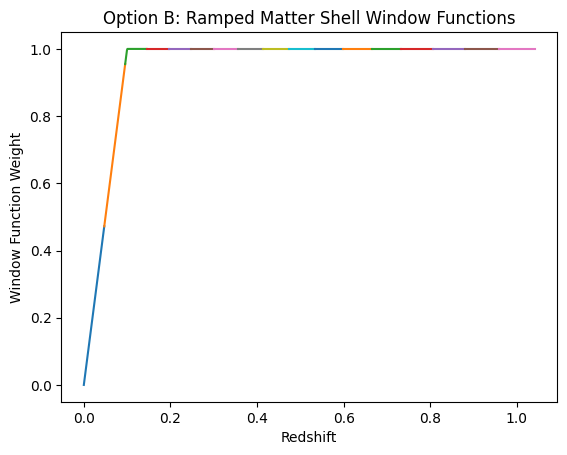

In [4]:
for i in ws_ramp:
    plt.plot(i.za, i.wa)
plt.title("Option B: Ramped Matter Shell Window Functions")
plt.xlabel("Redshift")
plt.ylabel("Window Function Weight")

The ramp seems to be necessary in CAMB for lower redshifts, and then it becomes identical to the constant version. Since Option B is the "improved" version, I will use this for the rest of the galaxy distribution generation.

In [5]:
# load the ramped angular matter power spectra previously computed with CAMB
ws = ws_ramp
cls = np.load('cls200ramp.npy')

Here, cls is a $(n(n+1)/2,\text{ lmax})$ array, where lmax is the angular powers and n is the number of shells as determined in glass.shells.distance_grid. The reason that it is $n(n+1)/2$ is that the $C_l$ s are stored as correlations between shells. This includes autocorrelations (one shell with itself), and every other possible correlation (one shell with another). Since we want every combination of shells, we end up with $ n\choose{2} $ = $n(n-1)/2$ $C_l$ arrays. We also add the autocorrelations, which add another n correlations, making it $n(n-1)/2 + n = n(n+1)/2$.

### Generating Matter in the Universe

Glass generates matter shells by taking the continuous matter field $\delta_c(z)$, and then projecting the matter field into shells of $\delta_i = \frac{\int \delta_c(z) W_i(z)dz}{\int W_i(z)dz}$. CAMB generates the angular matter power spectra, and GLASS simply gives CAMB the W_i(z) required for this. The precision of dz is determined when we are using the tophat_window function. We can define a dz < 0.001 if we want the integral to be more accurate, where 0.001 is the default. From the paper, "the angular power spectra completely determine the underlying physical model for matter in the simulation."
  
However, this is not sufficient to simulate the actual field $\delta_i$ - multiple random configurations may produce the same angular power spectra. Therefore, GLASS has to sample a random field on the sphere and imprint the correct one-point and two-point statistics onto them. It does this by generating a Gaussian random map $X$ on the sphere according to the angular matter power spectra, and then applying a (lognormal) transformation $Y = f(X) = \lambda (e^X - 1)$. Here, $X$ is a random variable, but we can think of it as a vector, with a value for each position $(\theta, \phi)$ on the sphere, sampled from a Gaussian. This random variable is then transformed according to the log normal. 
  
Lognormal is a popular, and more realistic choice for the random map that is generated than a Gaussian random field. The transformation would change the two-point statistics, so they adjust the map accordingly to maintain this (in very complex ways!). They then sample the Gaussian random field according the the new $G_l$ for $Y$ they calculate using, and analogous to, the $C_l$ from CAMB for $X$. These $G_l$ determine the coefficients of the harmonic series forming the density map:

$$ Y = \sum_{lm} a_{lm}Y_{lm} $$
 $$ a_{lm} = g(G_l) $$
  
where $Y_{lm}$ is the spherical harmonic (nothing to do with the Y on the LHS directly) and g is a function from the GLASS paper. This allows them to sample a realistic matter density field $\delta_i$.


In [6]:
# "compute Gaussian cls for lognormal fields for 3 correlated shells ahead and behind"
# is what they say -> I think they mean Gls, the equivalent of Cls for the transformed lognormal fields
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=2)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=2)

Here, gls is again of size $n \choose 2$, but only correlates the ncorr closest shells (including itself) - the rest are thrown out (empty list). ncorr = 3 is chosen since it is assumed shells beyond ncorr = 3 are uncorrelated. Anything that is not a correlation within ncorr = 3 is an empty list []. We have 62/153 remaining in our case with 17 shells. (153 is $17 \choose 2$)

ncorr = 1 for 17 shells means we have 33 gls remaining. This is because for each shell we have the autocorrelation (17) and the correlation of each shell with the shell before it (16). 17 + 16 = 33.

ncorr = 2 for 17 shells means that we have 48 gls remaining. This is because for each shell we have the autocorrelation (17) and the correlation of each shell with the shell before it (16) and the correlation with two shells before it (15). 17 + 16 + 15 = 48.

ncorr = 3 for 17 shells means that we have 62 gls remaining. 17 + 16 + 15 + 14 = 62.

matter is a Python generator which can generate the map of each shell with a call of next(matter) for computational reasons. We can also remove the point of a generator (memory saving) by just doing list(matter).

In [7]:
all_matter = np.array(list(matter))

In [8]:
# import healpy as hp
# from matplotlib.animation import FuncAnimation

# # Create a animation of matter map with redshift (z = 1 to now)
# fig, ax = plt.subplots()

# # Function to update the plot for each frame
# def update(frame):
#     ax.clear()  # Clear the previous plot
#     # Set plot labels and title (customize as needed)
#     proj_map = hp.mollview(all_matter[16 - frame], return_projected_map=True)
#     #ax.imshow(proj_map)
#     ax.imshow(proj_map)
#     ax.axis('off')
#     ax.set_title(f"Lognormal Matter Field at z={ws[16-frame].zeff.round(3)}")
#     #plt.axis    
# # Create the animation
# animation = FuncAnimation(fig, update, frames=17, interval=250, repeat=False)
# animation.save('matter_field_evol.gif', writer='imagemagick')
# plt.show()

### Generating galaxies from matter

In [42]:
# constant galaxy density distribution
z = np.linspace(0., 1.5, 100)
# 0.01 galaxies per arcmin sq.
# integrate over redshift to get total number of galaxies/arcmin sq.
dndz = np.full_like(z, 0.01) 

Text(0, 0.5, 'Galaxy Density (dn/dz)')

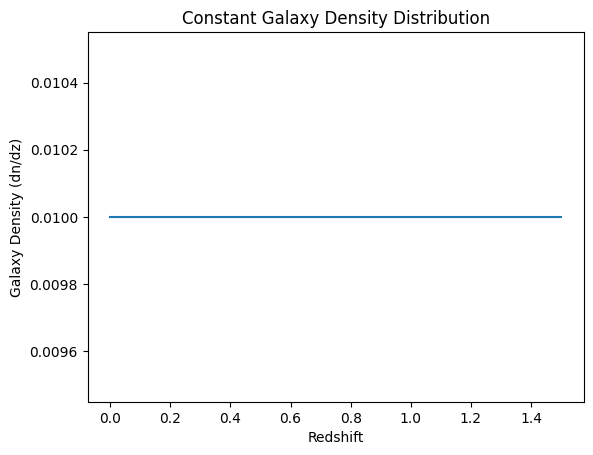

In [43]:
plt.plot(z, dndz)
plt.title("Constant Galaxy Density Distribution")
plt.xlabel("Redshift")
plt.ylabel("Galaxy Density (dn/dz)")

In [44]:
# make a cube for galaxy number in redshift
furthest_redshift_bound = zb[-1]
zcub = np.linspace(-furthest_redshift_bound, furthest_redshift_bound, 21)
cube = np.zeros((zcub.size - 1,)*3) # fancy way of making a 3D array of shape (20, 20, 20)

Here, `glass.points.positions_from_delta` is used to sample galaxies that trace the density contrast map delta_i. In reality, galaxies don't trace the dark matter exactly, they have some galaxy bias. This galaxy bias can be added (isn't added here yet) by adding `bias` kwarg, and specifying the `bias_model`. We can also add a visibility map `vis` in healpix terms, which is multiplied by the full sky count map. This is likely where we can imprint effects of our survey. The function also supports multi-dimensional input for the ``ngal``, ``delta``, ``bias``, and ``vis`` parameters, but I'm not entirely sure how that works yet.  

`glass.galaxies.redshifts_from_nz` then generates galaxy redshifts from a source distribution. 


In [45]:
# simulate and add galaxies in each matter shell to cube
for i, delta_i in enumerate(matter): # looping over each matter density shell difference

    # restrict galaxy distribution to this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i]) # dndz_i = dndz * ws[i].wa

    # compute galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i) #integrate total number of galaxies/arcmin2 in this shell

    # simulate positions from matter density
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal, delta_i):

        # sample redshifts uniformly in shell
        gal_z = glass.galaxies.redshifts_from_nz(gal_count, ws[i].za, ws[i].wa)

        # add counts to cube
        z1 = gal_z*np.cos(np.deg2rad(gal_lon))*np.cos(np.deg2rad(gal_lat))
        z2 = gal_z*np.sin(np.deg2rad(gal_lon))*np.cos(np.deg2rad(gal_lat))
        z3 = gal_z*np.sin(np.deg2rad(gal_lat))
        (i, j, k), c = np.unique(np.searchsorted(zcub[1:], [z1, z2, z3]), axis=1, return_counts=True)
        cube[i, j, k] += c

In [48]:
#glass.points.positions_from_delta?
glass.galaxies.redshifts_from_nz?

Signature:
glass.galaxies.redshifts_from_nz(
    count: 'int | ArrayLike',
    z: 'ArrayLike',
    nz: 'ArrayLike',
    *,
    rng: 'np.random.Generator | None' = None,
) -> 'np.ndarray'
Docstring:
Generate galaxy redshifts from a source distribution.

The function supports sampling from multiple populations of
redshifts if *count* is an array or if there are additional axes in
the *z* or *nz* arrays.  In this case, the shape of *count* and the
leading dimensions of *z* and *nz* are broadcast to a common shape,
and redshifts are sampled independently for each extra dimension.
The results are concatenated into a flat array.

Parameters
----------
count : int or array_like
    Number of redshifts to sample.  If an array is given, its shape
    is broadcast against the leading axes of *z* and *nz*.
z, nz : array_like
    Source distribution.  Leading axes are broadcast against the
    shape of *count*.
rng : :class:`~numpy.random.Generator`, optional
    Random number generator.  If not g